## 6: Feature Importances beyond Linear Models

### Outlines

- Explain why interpretability is important in ML.
- Use `feature_importances_` attribute of `sklearn` models and interpret its output. 
- Use `eli5` to get feature importances of non `sklearn` models and interpret its output. 
- Apply SHAP to assess feature importances and interpret model predictions. 
- Explain force plot, summary plot, and dependence plot produced with shapely values.  
- Explain the general concept of loss functions. 
- Explain the implications of changing the loss function. 

In [1]:
import os

%matplotlib inline
import string
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# data
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer

# Feature selection
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer

# classifiers / models
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV

# other
from sklearn.metrics import accuracy_score, log_loss, make_scorer, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier

## Interpretability of ML models: Motivations

### Why model interpretability? 

- Ability to interpret ML models is crucial in many applications such as banking, healthcare, and criminal justice.
- It can be leveraged by domain experts to diagnose systematic errors and underlying biases of complex ML systems. 

<center>
<img src="img/shap_example.png" width="600" height="600">
</center>
    
[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### What is model interpretability? 

- Here our definition of model iterpretability will be looking at **feature importances**.
- There is more to interpretability than feature importances, but it's a good start!
- Resource: 
    - [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/interpretability-importance.html)
    - [Yann LeCun, Kilian Weinberger, Patrice Simard, and Rich Caruana: Panel debate on interpretability](https://vimeo.com/252187813)

### Data

- Let's work with [the adult census data set](https://www.kaggle.com/uciml/adult-census-income) from last lecture. 

In [2]:
adult_df_large = pd.read_csv("data/adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)
train_df_nan.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5514,26,Private,256263,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,25,United-States,<=50K
19777,24,Private,170277,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,35,United-States,<=50K
10781,36,Private,75826,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32240,22,State-gov,24395,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,<=50K
9876,31,Local-gov,356689,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [3]:
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "native.country",
]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["race", "education.num"]
target_column = "income"

In [4]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [5]:
assert set(education_levels) == set(train_df["education"].unique())

In [6]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
tree_numeric_transformer = make_pipeline(SimpleImputer(strategy="median"))

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(categories=[education_levels], dtype=int),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
)

In [7]:
X_train = train_df_nan.drop(columns=[target_column])
y_train = train_df_nan[target_column]

X_test = test_df_nan.drop(columns=[target_column])
y_test = test_df_nan[target_column]

### Do we have class imbalance? 

- There is class imbalance. But without any context, both classes seem equally important. 
- Let's use accuracy as our metric. 

In [8]:
train_df_nan["income"].value_counts(normalize=True)

<=50K    0.757985
>50K     0.242015
Name: income, dtype: float64

In [9]:
scoring_metric = "accuracy"

Let's store all the results in a dictionary called `results`. 

In [10]:
results = {}

In [11]:
scoring_metric = "accuracy"

In [12]:
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
classifiers = {
    "logistic regression": pipe_lr,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
}

In [13]:
"""Function from lectures, thank you Varada"""
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [14]:
dummy = DummyClassifier(strategy="stratified")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [15]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

/opt/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use 

In [16]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.009 (+/- 0.001),0.007 (+/- 0.000),0.631 (+/- 0.001),0.632 (+/- 0.004)
logistic regression,1.110 (+/- 0.081),0.027 (+/- 0.004),0.850 (+/- 0.006),0.851 (+/- 0.001)
random forest,9.889 (+/- 0.341),0.127 (+/- 0.010),0.857 (+/- 0.004),1.000 (+/- 0.000)
XGBoost,1.277 (+/- 0.026),0.047 (+/- 0.002),0.871 (+/- 0.004),0.908 (+/- 0.001)
LightGBM,0.283 (+/- 0.011),0.053 (+/- 0.003),0.871 (+/- 0.004),0.892 (+/- 0.000)


- One problem is that often simple models are interpretable but not accurate.
- But more complex models (e.g., LightGBM) are less interpretable.

<center>
<img src="img/shap_motivation.png" width="600" height="600">
</center>    

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### Feature importances in linear models

- Simpler models are often more interpretable but less accurate. 

Let's create and fit a pipeline with preprocessor and logistic regression. 

In [17]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, random_state=2))
pipe_lr.fit(X_train, y_train);

In [18]:
ohe_feature_names = (
    pipe_rf.named_steps["columntransformer"]
    .named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names()
    .tolist()    # this was an array
)
feature_names = (
    numeric_features + ordinal_features + binary_features + ohe_feature_names
)
feature_names[:10]

/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['age',
 'fnlwgt',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'education',
 'sex',
 'x0_Federal-gov',
 'x0_Local-gov',
 'x0_Never-worked']

In [19]:
pipe_lr.named_steps["logisticregression"].coef_    # this was a [[]] list

array([[ 3.59670415e-01,  7.82098457e-02,  2.35598583e+00,
         2.81041652e-01,  3.70178512e-01,  1.84080859e-01,
         8.75326111e-01,  6.56575622e-01,  4.07885327e-02,
        -1.72139433e-01,  1.93907208e-01,  4.91773660e-01,
        -1.49875168e-01, -6.30094851e-02, -9.30294480e-01,
        -3.27029992e-02, -5.25240265e-01,  1.76077583e+00,
         1.35115578e+00, -4.51226131e-01, -9.36551436e-01,
        -6.60125914e-01, -5.03764407e-01,  1.62403899e-01,
        -3.82406534e-01,  1.96389845e-01,  1.05111077e+00,
        -9.35154254e-01, -5.51405082e-01, -1.76152681e-01,
        -7.35020533e-01, -1.40245784e+00,  1.07434511e+00,
         6.16016024e-01,  4.86866942e-01,  8.17434921e-01,
         1.78952991e-02, -2.04842433e-01, -1.13007239e-02,
         2.12087693e-01, -5.28020350e-01, -9.84038864e-01,
         6.31919532e-02,  1.28310375e+00,  6.90381773e-01,
         4.32148085e-01, -2.59874132e-01, -1.10948836e+00,
         4.10911720e-01, -1.01404179e+00,  1.13496990e-0

In [20]:
data = {
    "coefficient": pipe_lr.named_steps["logisticregression"].coef_[0].tolist(),
    "magnitude": np.absolute(
        pipe_lr.named_steps["logisticregression"].coef_[0].tolist()
    ),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "magnitude", ascending=False
)

In [21]:
coef_df[:10]

,coefficient,magnitude
capital.gain,2.355986,2.355986
x1_Married-AF-spouse,1.760776,1.760776
x2_Priv-house-serv,-1.402458,1.402458
x1_Married-civ-spouse,1.351156,1.351156
x3_Wife,1.283104,1.283104
x4_Columbia,-1.109488,1.109488
x2_Prof-specialty,1.074345,1.074345
x2_Exec-managerial,1.051111,1.051111
x4_Dominican-Republic,-1.014042,1.014042
x3_Own-child,-0.984039,0.984039


- Increasing `capital.gain` is likely to push the prediction towards ">50k" income class 
- Whereas occupation of private house service is likely to push the prediction towards "<=50K" income. 

Can we get feature importances for non-linear models? 

<br><br>

## Model interpretability beyond linear models

We will be looking at three ways for model interpretability. 

- `sklearn` `feature_importances_`    
- [eli5](https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html#lime-tutorial) (stands for "explain like I'm 5") 
- [SHAP](https://github.com/slundberg/shap)
    

### `sklearn` `feature_importances_`

- Many `sklearn` models have `feature_importances_` attribute.
- For tree-based models it's calculated based on impurity (gini index or information gain).
- For example, let's look at `feature_importances_` of `RandomForestClassifier`. 

Let's create and fit a pipeline with preprocessor and random forest. 

In [22]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=2))
pipe_rf.fit(X_train, y_train);

Which features are driving the predictions the most? 

In [23]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
imps = pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]
imps

,Importance
fnlwgt,0.169580
age,0.153339
education,0.102953
capital.gain,0.097686
hours.per.week,0.085583
x1_Married-civ-spouse,0.064646
x3_Husband,0.048896
capital.loss,0.033387
x1_Never-married,0.028629
x2_Exec-managerial,0.020458


### Key point 

- Unlike the linear model coefficients, `feature_importances_` **do not have a sign**!
  - They tell us about importance, but not an "up or down".
  - Indeed, increasing a feature may cause the prediction to first go up, and then go down.
  - This cannot happen in linear models, because they are linear. 

Do these importances match with importances identified by logistic regression? 

In [24]:
data = {
    "random forest importance": pipe_rf.named_steps[
        "randomforestclassifier"
    ].feature_importances_,
    "logistic regression importances": pipe_lr.named_steps["logisticregression"]
    .coef_[0]
    .tolist(),
}
imps = pd.DataFrame(
    data=data,
    index=feature_names,
)

In [25]:
imps.sort_values(by="random forest importance", ascending=False)[:10]

,random forest importance,logistic regression importances
fnlwgt,0.169580,0.078210
age,0.153339,0.359670
education,0.102953,0.184081
capital.gain,0.097686,2.355986
hours.per.week,0.085583,0.370179
x1_Married-civ-spouse,0.064646,1.351156
x3_Husband,0.048896,-0.011301
capital.loss,0.033387,0.281042
x1_Never-married,0.028629,-0.936551
x2_Exec-managerial,0.020458,1.051111


- Both models agree on `age`, `education`, `capital.gain`
- The actual numbers for random forests and logistic regression are not really comparable. 

### How can we get feature importances for non `sklearn` models? 

- One way to do it is by using a tool called [`eli5`](https://eli5.readthedocs.io/en/latest/overview.html).

You'll have to install it

```
conda install -c conda-forge eli5
```

Let's look at feature importances for `XGBClassifier`. 

```{note}
For some reason, `eli5.explain_weights` doesn't work with the latest version of `xgboost`. I downgraded the `xgboost` version using this command to make it work `conda install -c conda-forge py-xgboost==1.3.0`. 

```

In [26]:
import eli5

# pipe_xgb = make_pipeline(preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0))
# pipe_xgb.fit(X_train, y_train);
# eli5.explain_weights(pipe_xgb.named_steps["xgbclassifier"], feature_names=feature_names)

Let's look at feature importances for `LGBMClassifier`. 

In [27]:
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_lgbm.fit(X_train, y_train)
eli5.explain_weights(
    pipe_lgbm.named_steps["lgbmclassifier"], feature_names=feature_names
)

Weight,Feature
0.3558,x1_Married-civ-spouse
0.1910,capital.gain
0.1363,education
0.0852,age
0.0639,capital.loss
0.0418,hours.per.week
0.0245,fnlwgt
0.0134,x2_Exec-managerial
0.0120,x2_Prof-specialty
0.0067,x2_Other-service


You can also look at feature importances for `RandomForestClassifier`. 

In [28]:
eli5.explain_weights(
    pipe_rf.named_steps["randomforestclassifier"], feature_names=feature_names
)

Weight,Feature
0.1696 ± 0.0113,fnlwgt
0.1533 ± 0.0396,age
0.1030 ± 0.0348,education
0.0977 ± 0.0479,capital.gain
0.0856 ± 0.0250,hours.per.week
0.0646 ± 0.1385,x1_Married-civ-spouse
0.0489 ± 0.1117,x3_Husband
0.0334 ± 0.0157,capital.loss
0.0286 ± 0.0740,x1_Never-married
0.0205 ± 0.0211,x2_Exec-managerial


Let's compare them with weights what we got with `sklearn` `feature_importances_`

In [29]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]

,Importance
fnlwgt,0.169580
age,0.153339
education,0.102953
capital.gain,0.097686
hours.per.week,0.085583
x1_Married-civ-spouse,0.064646
x3_Husband,0.048896
capital.loss,0.033387
x1_Never-married,0.028629
x2_Exec-managerial,0.020458


- These values tell us globally about which features are important.
- But what if you want to explain a _specific_ prediction. 
- Some fancier tools can help us do this.

<br><br><br><br>

## SHAP  (SHapley Additive exPlanations)

#### SHAP  (SHapley Additive exPlanations)
- A sophisticated measure of the contribution of each feature.
- [Lundberg and Lee, 2017](https://arxiv.org/pdf/1705.07874.pdf)
- We won't go in details. You may refer to [Scott Lundberg's GitHub repo](https://github.com/slundberg/shap) if you are interested to know more. 


### General idea

<center>
<img src="img/shap_example.png" width="600" height="600">
</center>

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### General idea

- Provides following kind of explanation
    - Start at a base rate (e.g., how often people get their loans rejected).
    - Add one feature at a time and see how it impacts the decision. 


<center>
<img src="img/shap_explanation2.png" width="1000" height="1000">
</center>

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)


Let's try it out on tree-based models. 

First you'll have to install it. 

```
pip install shap
or
conda install -c conda-forge shap
```

Let's create train and test dataframes with our transformed features. 

In [30]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

,age,fnlwgt,capital.gain,capital.loss,hours.per.week,education,sex,x0_Federal-gov,x0_Local-gov,x0_Never-worked,...,x4_Puerto-Rico,x4_Scotland,x4_South,x4_Taiwan,x4_Thailand,x4_Trinadad&Tobago,x4_United-States,x4_Vietnam,x4_Yugoslavia,x4_missing
5514,-0.921955,0.632531,-0.147166,-0.21768,-1.258387,8.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19777,-1.069150,-0.186155,-0.147166,-0.21768,-0.447517,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10781,-0.185975,-1.085437,-0.147166,-0.21768,-0.042081,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32240,-1.216346,-1.575119,-0.147166,-0.21768,-1.663822,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9876,-0.553965,1.588701,-0.147166,-0.21768,-0.042081,13.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)

X_test_enc.shape

(6513, 86)

Let's get SHAP values for train and test data. 

In [32]:
import shap

lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [33]:
train_lgbm_shap_values[1].shape

(26048, 86)

In [34]:
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)
test_lgbm_shap_values[1].shape

(6513, 86)

- For classification it's a bit confusing. It gives SHAP arrays both classes.
- Let's stick to shap values for class 1, i.e., income > 50K. 

For each example and each feature we have a SHAP value. 

In [35]:
train_lgbm_shap_values[1]

array([[-4.23243013e-01, -5.89878323e-02, -2.65263112e-01, ...,
         9.63030623e-04,  0.00000000e+00,  5.74466631e-04],
       [-6.83190014e-01,  1.15708200e-02, -2.72482485e-01, ...,
         8.17274476e-04,  0.00000000e+00,  8.09406158e-04],
       [ 4.49106369e-01, -1.32455245e-01, -2.39454581e-01, ...,
         8.27603313e-04,  0.00000000e+00,  4.22023416e-03],
       ...,
       [ 1.02714900e+00,  2.38119557e-02, -1.88163464e-01, ...,
         1.13580827e-03,  0.00000000e+00,  6.94390861e-04],
       [ 6.37084418e-01,  2.90573592e-02, -3.03429292e-01, ...,
         9.70726909e-04,  0.00000000e+00,  2.16856964e-03],
       [-1.24950883e+00,  1.19867799e-01, -2.23378846e-01, ...,
         9.70674774e-04,  0.00000000e+00,  9.73838044e-04]])

Let's look at the average SHAP values associated with each feature. 

In [36]:
values = np.abs(train_lgbm_shap_values[1]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
x1_Married-civ-spouse,1.086269
age,0.823933
capital.gain,0.572778
education,0.409543
hours.per.week,0.313901
sex,0.188874
capital.loss,0.138607
x3_Own-child,0.112871
x2_Exec-managerial,0.107399
x2_Prof-specialty,0.098181


You can think of this as global feature importances.

<br><br><br><br>

## SHAP plots

In [37]:
# load JS visualization code to notebook
shap.initjs()

### Dependence plot

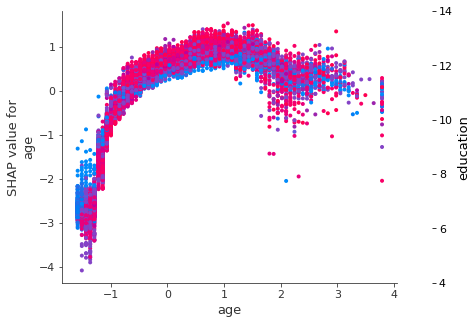

In [38]:
shap.dependence_plot("age", train_lgbm_shap_values[1], X_train_enc)

The plot above shows effect of `age` feature on the prediction. 

- Each dot is a single prediction for examples above.
- The x-axis represents values of the feature age (scaled).
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that example's prediction. 
- Lower values of age have smaller SHAP values for class ">50K".
- Similarly, higher values of age also have a bit smaller SHAP values for class ">50K", which makes sense.  
- There is some optimal value of age between scaled age of 1 which gives highest SHAP values for for class ">50K". 
- Ignore the colour for now. The color corresponds to a second feature (education feature in this case) that may have an interaction effect with the feature we are plotting. 

### Summary plot 

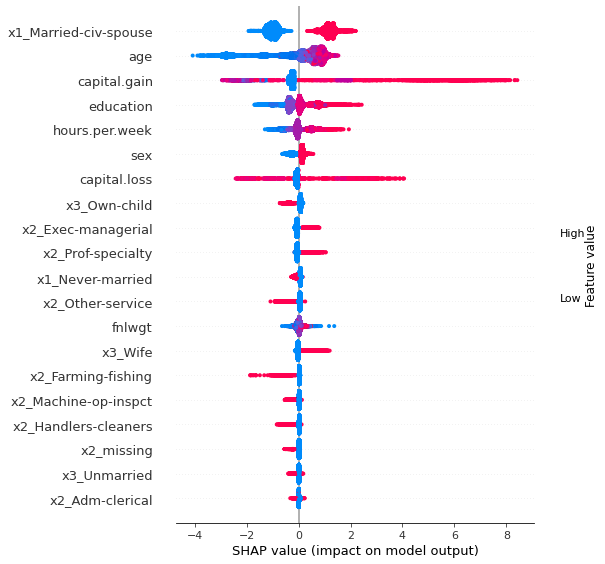

In [39]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc)

The plot shows the most important features for predicting the class. It also shows the direction of how it's going to drive the prediction.  

- Presence of the marital status of Married-civ-spouse seems to have bigger SHAP values for class 1 and absence seems to have smaller SHAP values for class 1. 
- Higher levels of education seem to have bigger SHAP values for class 1 whereas smaller levels of education have smaller SHAP values. 

Notes: the colors indicate low to high of the feature values, and the x-axis denotes the SHAP value.

### Force plot 

- Let's try to explain predictions on a couple of examples from the test data. 
- We are sampling some examples where target is <=50K and some examples where target is >50K. 

In [40]:
y_test_reset = y_test.reset_index(drop=True)
y_test_reset

0       <=50K
1       <=50K
2       <=50K
3       <=50K
4       <=50K
        ...  
6508    <=50K
6509    <=50K
6510     >50K
6511    <=50K
6512     >50K
Name: income, Length: 6513, dtype: object

In [41]:
l50k_ind = y_test_reset[y_test_reset == "<=50K"].index.tolist()
g50k_ind = y_test_reset[y_test_reset == ">50K"].index.tolist()

ex_l50k_index = l50k_ind[10]
ex_g50k_index = g50k_ind[10]

### Example with prediction <=50K

In [42]:
pipe_lgbm.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[ex_l50k_index]

array([0.98998011, 0.01001989])

In [43]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)[
    ex_l50k_index
]  # raw score of the model

-4.59311253704159

In [44]:
lgbm_explainer.expected_value[1]

-2.3163172510079377

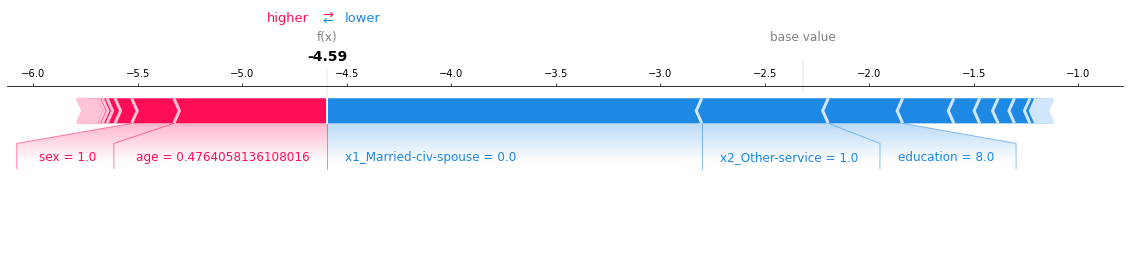

In [45]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_l50k_index, :],
    X_test_enc.iloc[ex_l50k_index, :],
    matplotlib=True,
)

- The raw model score is smaller than the base value so the prediction is <=50K (because we are considering the shap values for class 1). 

### Example with prediction >50K

In [46]:
pipe_lgbm.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[ex_g50k_index]

array([0.47228832, 0.52771168])

In [47]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)[
    ex_g50k_index
]  # raw model score

0.11096043410156158

In [48]:
g50k_ind[:10]

[17, 18, 30, 31, 39, 45, 49, 58, 59, 62]

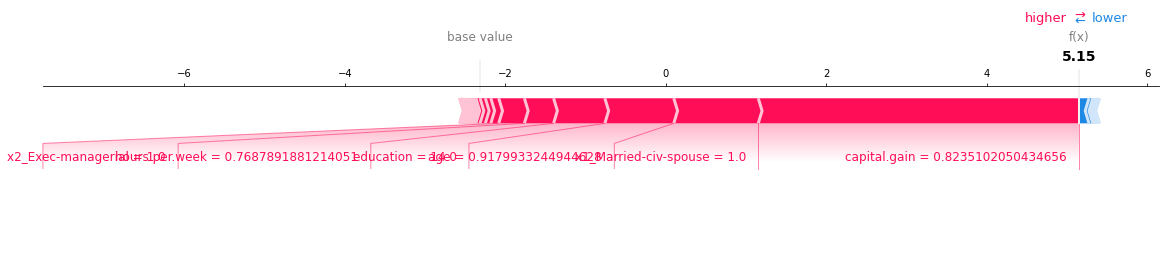

In [49]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][18, :],
    X_test_enc.iloc[18, :],
    matplotlib=True,
)

In [50]:
test_lgbm_shap_values[1][ex_g50k_index, :],

(array([ 7.06576926e-01,  4.48050353e-02, -3.04826888e-01, -8.90345564e-02,
        -7.60234999e-01,  7.99009432e-01,  1.59145115e-01, -1.04561236e-02,
         1.12544519e-02,  0.00000000e+00, -7.93711497e-03, -8.36423421e-03,
        -4.36341788e-02,  7.59578850e-03,  0.00000000e+00,  2.58025291e-03,
        -1.21233828e-03,  0.00000000e+00,  1.08073198e+00, -1.96300214e-03,
         4.05063596e-02,  3.89528728e-03, -3.40493462e-03,  1.13966166e-02,
         0.00000000e+00,  1.78540517e-02, -9.45890343e-03,  2.07052478e-02,
         4.68861970e-03,  2.04262116e-02,  5.73720200e-02,  4.04716758e-03,
         6.91720232e-01, -4.07221602e-03, -1.66621103e-02, -1.42348633e-02,
         8.08173720e-03,  1.52914770e-02,  8.16100692e-03, -1.52031143e-02,
         4.30523314e-03,  3.49488337e-02,  1.95922173e-02, -7.73110056e-02,
         0.00000000e+00, -1.86454897e-04,  9.32582520e-04,  2.43918385e-03,
        -3.25037985e-04,  1.48300302e-03,  0.00000000e+00,  0.00000000e+00,
         0.0

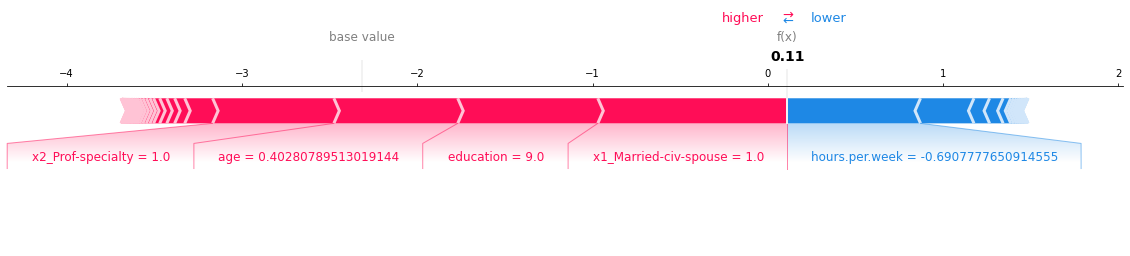

In [51]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_g50k_index, :],
    X_test_enc.iloc[ex_g50k_index, :],
    matplotlib=True,
)

- The raw model score is bigger than the base value so the prediction is >50K (because we are consider the shap values for class 1). 

Observations: 

- Everything is with respect to class 1 here. 
- The base value for class 1 is -2.316. (You can think of this as the average raw score.) 
- We see the forces that drive the prediction. 
- That is, we can see the main factors pushing it from the base value (average over the dataset) to this particular prediction. 
- Features that push the prediction to a higher value are shown in red. 
- Features that push the prediction to a lower value are shown in blue.

Note: a nice thing about SHAP values is that the feature importances sum to the prediction:

In [52]:
test_lgbm_shap_values[1][ex_g50k_index, :].sum() + lgbm_explainer.expected_value[1]

0.11096043410156309

Provides explainer for different kinds of models

- [TreeExplainer](https://shap.readthedocs.io/en/latest/) (supports XGBoost, CatBoost, LightGBM) 
- [DeepExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.DeepExplainer) (supports deep-learning models)
- [KernelExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.KernelExplainer) (supports kernel-based models)
- [GradientExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.GradientExplainer) (supports Keras and Tensorflow models)


- Can also be used to explain text classification and image classification 
- Example: In the picture below, red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values that reduce the probability of the class. 

<img src="img/shap_image_explainer.png" width="600" height="600">

[Source](https://github.com/slundberg/shap)

### Other tools

- [lime](https://github.com/marcotcr/lime) is another package.

If you're not already impressed, keep in mind:

- So far we've only used sklearn models.
- Most sklearn models have some built-in measure of feature importances.
- On many tasks we need to move beyond sklearn, e.g. LightGBM, deep learning.
- These tools work on other models as well, which makes them extremely useful.

#### Why do we want this information?

Possible reasons:

- Identify features that are not useful and maybe remove them.
- Get guidance on what new data to collect.
  - New features related to useful features -> better results.
  - Don't bother collecting useless features -> save resources.
- Help explain why the model is making certain predictions. 
  - Debugging, if the model is behaving strangely.
  - Regulatory requirements.
  - Fairness / bias.
  - Keep in mind this can be used on **deployment** predictions!

## Introduction to loss functions

In [53]:
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, LogisticRegression



- We have seen least squares for linear regression:

$$\min_w \sum_{i=1}^n \left(w^Tx_i - y_i\right)^2$$

- (Note: we will use $w$ instead of $\beta$ for the regression coefficients / weights.)
- This function that we're minimizing is called the **loss function**.

#### Example: robust linear regression

- An example of a different loss function would be the absolute value loss:

$$\min_w \sum_{i=1}^n \left| w^Tx_i - y_i \right|$$

- What are the implications of switching between these different choices? 


In [54]:
def lr_loss_squared(w, X, y):
    return np.sum((X @ w - y) ** 2)

In [55]:
def lr_loss_abs(w, X, y):
    return np.sum(np.abs(X @ w - y))

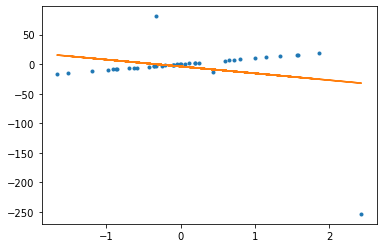

In [56]:
def gen_outlier_data(n=40, Noutliers=3):
    # generate random data
    x = np.random.randn(n)
    y = 10 * x
    # add random outliers
    y[:Noutliers] = -100 * (x[:Noutliers] + np.random.randn(Noutliers))

    X = x[:, None]  # reshape for sklearn

    return X, y


np.random.seed(5)

X, y = gen_outlier_data()
lr = LinearRegression()
lr.fit(X, y)

plt.plot(X, y, ".")
plt.plot(X, lr.predict(X));

In [57]:
X_1 = np.concatenate((X, np.ones(X.shape)), axis=1)

In [58]:
w_min = minimize(lr_loss_squared, np.zeros(2), args=(X_1, y)).x

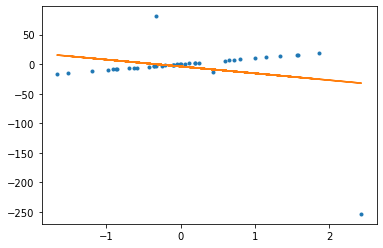

In [59]:
plt.plot(X, y, ".")
plt.plot(X, X_1 @ w_min);

In [60]:
w_min_abs = minimize(
    lr_loss_abs, np.zeros(2), args=(X_1, y)
).x  # don't try this at home

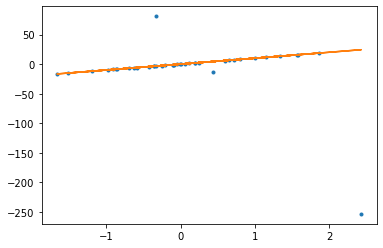

In [61]:
plt.plot(X, y, ".")
plt.plot(X, X_1 @ w_min_abs);

- So, it seems like we got very diffrent fits by changing the loss function.
- In this case, the absolute loss gave us robust regression.
- The loss function is important!

### Aside: an interpretation of the mean and median

- The mean is the number that minimizes the squared loss between itself and the set of numbers.
- The median is the number that minimizes the absolute loss between itself and the set of numbers.

So if you believe the median is more robust than the mean, you should believe the absolute value loss is more robust than the squared loss.

In [62]:
nums = np.array([1, 7, 4, -3, 3.4, 100, 50])

print("Mean of the numbers:", np.mean(nums))
print("Median of the numbers:", np.median(nums))

Mean of the numbers: 23.2
Median of the numbers: 4.0


In [63]:
squared_loss = lambda x: np.sum(np.square(x - nums))
print(
    "Value the minimizes the squared distance from the numbers:",
    minimize(squared_loss, 0).x,
)

Value the minimizes the squared distance from the numbers: [23.19999869]


In [64]:
absolute_loss = lambda x: np.sum(np.abs(x - nums))
print(
    "Value the minimizes the absolute value distance from the numbers:",
    minimize(absolute_loss, 0).x,
)

Value the minimizes the absolute value distance from the numbers: [3.99999999]


### Back to the big picture

We can start to think of (a lot of) ML as a 3-step process:

1. Choose your model
2. Choose your loss function
3. Choose your optimization algorithm

What do these do?

1. The model controls the space of possible functions from $X$ to $y$.
  - For example, a linear model can only learn linear functions.
2. The loss function tells us how to compare these various functions.
  - For example, is $y=2x_1+3x_2$ a better model than $y=10x_1-x_2$?
3. The optimization algorithm computationally finds the minimum of the loss function. 

#### Loss function example: logistic regression vs. SVM

In [65]:
n = 100
d = 2

X = np.random.rand(n, d)
y = np.random.choice((-1, +1), size=n, replace=True)
X[y == 1, 0] += 0.5

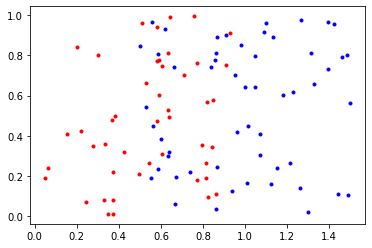

In [66]:
plt.plot(X[y == -1, 0], X[y == -1, 1], ".r")
plt.plot(X[y == 1, 0], X[y == 1, 1], ".b");

In [67]:
y = y[:, None]

In [68]:
def plot_loss_2d(loss_fun, title="", nw1=100, nw2=100):
    wmin = -5
    wmax = 5
    w1_lin = np.linspace(wmin, wmax, nw1)
    w2_lin = np.linspace(wmin, wmax, nw2)
    w1_grid, w2_grid = np.meshgrid(w1_lin, w2_lin)

    w1_flat = w1_grid.flatten()
    w2_flat = w2_grid.flatten()

    W = np.concatenate((w1_flat[None], w2_flat[None]), axis=0)

    loss_flat = loss_fun(W, X, y)
    loss_grid = np.reshape(loss_flat, (nw1, nw2))

    #     plt.imshow(loss_grid, extent=(np.min(w1_lin), np.max(w1_lin), np.min(w2_lin), np.max(w2_lin)), origin='lower')
    CS = plt.contour(w1_grid, w2_grid, loss_grid, levels=20)

    imin = np.argmin(loss_grid)
    plt.plot(w1_flat[imin], w2_flat[imin], "r*", markersize=15)

    plt.xlabel("$w_1$")
    plt.ylabel("$w_2$")
    plt.title(title)


#     plt.colorbar();

- Logistic regression are both linear classifiers, but they use different loss functions.
- These differences have some implications, like the idea of "support vectors".
- We can visulalize these loss functions below:

In [69]:
def loss_lr(w, X, y, λ=1e-3):
    return np.sum(np.log(1 + np.exp(-y * (X @ w))), axis=0) + λ * np.sum(w ** 2, axis=0)


def loss_svm(w, X, y, λ=1e-3):
    return np.sum(np.maximum(0, 1 - y * (X @ w)), axis=0) + λ * np.sum(w ** 2, axis=0)

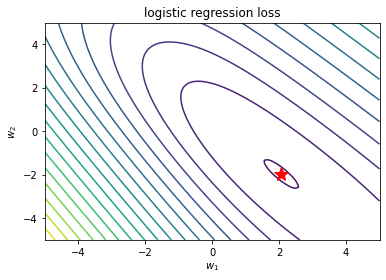

In [70]:
plot_loss_2d(loss_lr, "logistic regression loss")

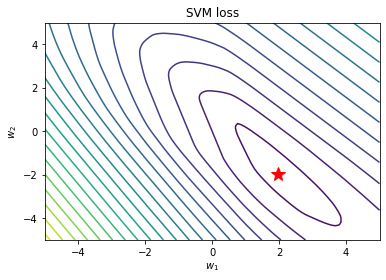

In [71]:
plot_loss_2d(loss_svm, "SVM loss")

- In practice, we need to use different methods to minimize these functions, because the SVM loss is non-smooth.
- We can see more of the non-smoothness below if we take a vertical slice of these 2d contour plots.

In [72]:
def plot_loss_1d(loss_fun, title="", w1=0):
    w2_grid = np.linspace(-5, 5, 5000)
    w = np.zeros((2, len(w2_grid)))
    w[1] = w2_grid  # vary w2
    w[0] = w1
    loss_slice = loss_fun(w, X, y)
    plt.plot(w2_grid, loss_slice)
    plt.xlabel("$w_2$")
    plt.ylabel("loss")
    plt.title(title);

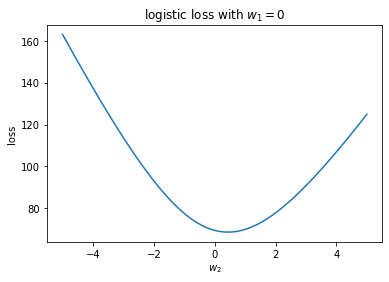

In [73]:
plot_loss_1d(loss_lr, "logistic loss with $w_1=0$")

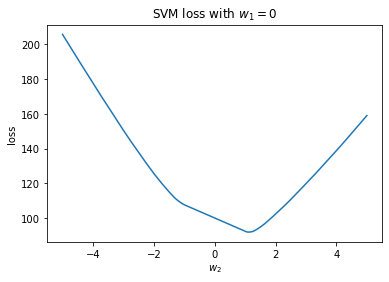

In [74]:
plot_loss_1d(loss_svm, "SVM loss with $w_1=0$");

### Notes

1. You train a random forest on a binary classification problem with two classes [neg, pos]. A value of 0.580 for feat1 given by `feature_importances_` attribute of your model doesn't mean that increasing the value of feat1 will drive us towards positive class!! **You should be really careful with the value of `feature_importances` because they don't indicate the direction that the feature is influencing the prediction result.**
2. eli5 can be used to get feature importances for non `sklearn` models.
3. With SHAP you can not only explain predictions on the training examples, but also the prediction examples.
4. When you add up the shapely values for an example and the expected value, you don't always get the same score as `predict_proba` output. For random forests you do get `predict_proba` scores but for light GBMs you don't.